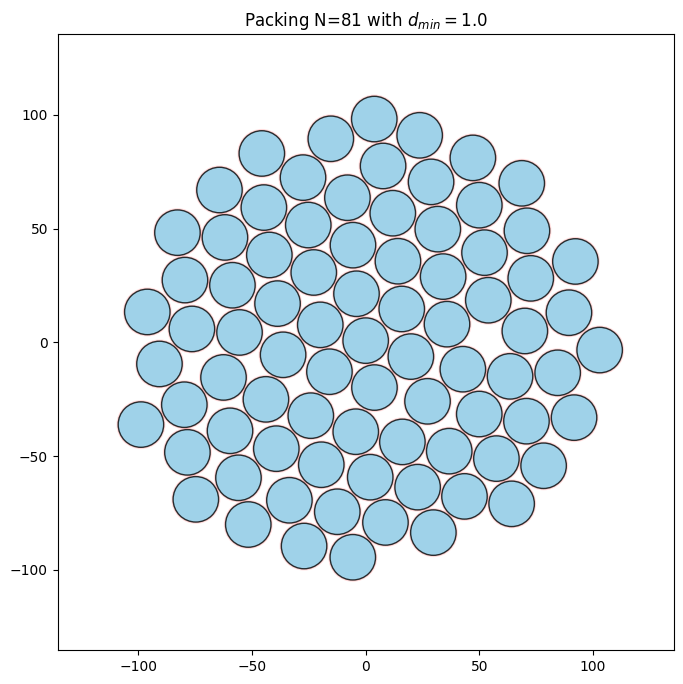

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def pack_circles(radii, d_min=0.0):
    """
    Packs circles with a mandatory minimum spacing (d_min) between them.
    
    Args:
        radii (list): List of radius values.
        d_min (float): Minimum distance required between any two circle edges.
        
    Returns:
        dict: {index: [x, y]}
    """
    N = len(radii)
    radii = np.array(radii)
    
    # --- Fix 1: Randomize Order ---
    # We shuffle indices to prevent "small particles in center" bias.
    # We will map them back to their original indices at the end.
    shuffled_indices = np.arange(N)
    np.random.shuffle(shuffled_indices)
    
    radii_shuffled = radii[shuffled_indices]
    
    # Initialize random positions
    max_r = np.max(radii)
    # Slightly larger spread to accommodate d_min
    initial_spread = (max_r + d_min) * np.sqrt(N) * 1.5
    positions = np.random.uniform(-initial_spread, initial_spread, size=(N, 2))
    
    # Simulation settings
    iterations = 2000
    dt = 0.1
    k_center = 0.5
    k_repel = 1.0
    
    for i in range(iterations):
        # 1. Calculate Distances
        delta = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
        dist_sq = np.sum(delta**2, axis=2)
        dist = np.sqrt(dist_sq)
        
        # Avoid 0/0 errors
        dist[dist == 0] = 1e-7
        
        # 2. Calculate Overlap with d_min
        # The required distance is sum of radii PLUS d_min
        radii_sum = radii_shuffled[:, np.newaxis] + radii_shuffled[np.newaxis, :]
        required_dist = radii_sum + d_min
        
        overlaps = required_dist - dist
        
        # Ignore self-interaction and non-overlaps
        np.fill_diagonal(overlaps, -1)
        mask = overlaps > 0
        
        # 3. Annealing Logic
        # Relax gravity near the end to ensure d_min is strictly respected
        if i > iterations * 0.8:
            current_k_center = 0.05 # Keep a tiny pull to prevent drifting to infinity
            current_k_repel = k_repel * 2.0 # Stiff repulsion to lock in d_min
        else:
            current_k_center = k_center
            current_k_repel = k_repel

        # 4. Apply Forces
        norm_delta = delta / dist[..., np.newaxis]
        
        # Repulsion acts to satisfy (r_i + r_j + d_min)
        repel_force = np.sum(mask[..., np.newaxis] * norm_delta * overlaps[..., np.newaxis], axis=1) * current_k_repel * 0.5
        
        center_force = -positions * current_k_center
        
        move = (repel_force + center_force) * dt
        positions += move
        
        # Early exit check
        if i > 200 and np.max(np.abs(move)) < 1e-5 and not np.any(mask):
            break

    # 5. Final Geometric Cleanup (The "Polishing" Step)
    # This loop strictly enforces d_min regardless of physics forces
    for _ in range(500):
        delta = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
        dist = np.sqrt(np.sum(delta**2, axis=2))
        dist[dist == 0] = 1e-7
        
        radii_sum = radii_shuffled[:, np.newaxis] + radii_shuffled[np.newaxis, :]
        required_dist = radii_sum + d_min
        
        overlaps = required_dist - dist
        np.fill_diagonal(overlaps, -1)
        mask = overlaps > 0
        
        if not np.any(mask):
            break
            
        norm_delta = delta / dist[..., np.newaxis]
        correction = np.sum(mask[..., np.newaxis] * norm_delta * overlaps[..., np.newaxis], axis=1) * 0.5
        positions += correction

    # --- Restore Original Order ---
    # We computed positions for shuffled indices, now we put them back
    # into the dictionary using the original indices.
    output_dict = {}
    for shuffled_idx, original_idx in enumerate(shuffled_indices):
        output_dict[original_idx] = positions[shuffled_idx].tolist()
        
    return output_dict

# --- Visualization Helper ---
def visualize_packing(radii, d_min, packed_dict):
    fig, ax = plt.subplots(figsize=(8, 8))
    all_coords = np.array(list(packed_dict.values()))
    max_extent = np.max(np.abs(all_coords)) + np.max(radii)
    ax.set_xlim(-max_extent*1.2, max_extent*1.2)
    ax.set_ylim(-max_extent*1.2, max_extent*1.2)
    
    for i, (x, y) in packed_dict.items():
        r = radii[i]
        # Draw the actual particle
        circle = plt.Circle((x, y), r, color='skyblue', alpha=0.8, ec='black', zorder=2)
        ax.add_patch(circle)
        
        # VISUALIZATION TRICK: Draw the "exclusion zone" (d_min)
        # This shows the buffer area. If circles overlap this dashed line, d_min is violated.
        buffer_radius = r + d_min/2
        buffer = plt.Circle((x, y), buffer_radius, color='red', alpha=0.1, zorder=1) #, linestyle='--')
        ax.add_patch(buffer)

    ax.set_aspect('equal')
    ax.set_title(f"Packing N={len(radii)} with $d_{{min}}={d_min}$")
    plt.show()

# --- Run Example ---
if __name__ == "__main__":
    # Test: 150 particles
    N_circles = 81
    my_radii = np.full(N_circles, 10.0)
    my_d_min = 1.0  # Significant gap
    
    packed_result = pack_circles(my_radii, d_min=my_d_min)
    
    visualize_packing(my_radii, my_d_min, packed_result)

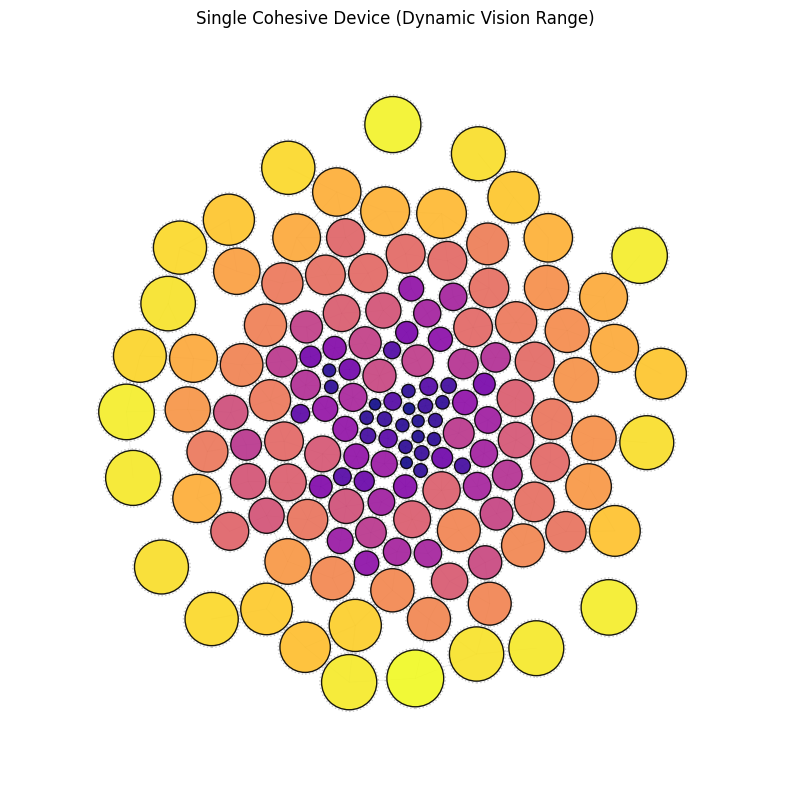

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def pack_circles_single_cluster(radii, d_min=0.0):
    """
    Creates a single cohesive cluster by annealing the interaction range:
    starts with global attraction (gathering) and ends with local lattice locking.
    """
    N = len(radii)
    radii = np.array(radii)
    
    # --- 1. Initialization ---
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    # Initial spread
    total_area = np.sum(np.pi * (radii + d_min)**2)
    start_radius = np.sqrt(total_area) * 2.0
    
    theta = np.random.uniform(0, 2*np.pi, N)
    r_pos = np.sqrt(np.random.uniform(0, 1, N)) * start_radius
    x = r_pos * np.cos(theta)
    y = r_pos * np.sin(theta)
    positions = np.column_stack((x, y))

    # --- 2. Simulation Settings ---
    iterations = 3000
    dt = 0.02
    
    k_repel = 20.0     # Strong repulsion to prevent overlap
    k_attract = 0.8    # Standard attraction
    max_force = 5.0    # Safety clamp
    
    # ANNEALING PARAMETERS
    # Start looking for neighbors 50x radii away (effectively global)
    # End looking 2.5x radii away (nearest neighbors only)
    start_cutoff = 50.0 
    end_cutoff = 2.5

    # --- 3. Physics Loop ---
    for step in range(iterations):
        progress = step / iterations
        
        # Dynamic Cutoff: Shrinks over time
        # We use a power curve (progress^2) so it stays long-range for a while
        # then snaps to short-range at the end.
        current_cutoff = start_cutoff + (end_cutoff - start_cutoff) * (progress**0.5)
        
        # --- Distance Calculations ---
        delta = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
        dist_sq = np.sum(delta**2, axis=2)
        dist = np.sqrt(dist_sq)
        
        # Safe distance for division
        safe_dist = dist.copy()
        safe_dist[safe_dist < 1e-7] = 1e-7
        norm_delta = delta / safe_dist[..., np.newaxis]
        
        # Target: exact spacing we want
        radii_sum = radii[:, np.newaxis] + radii[np.newaxis, :]
        target_dist = radii_sum + d_min
        
        # Diff: Negative=Overlap, Positive=Gap
        diff = dist - target_dist
        np.fill_diagonal(diff, np.inf)
        
        # --- Forces ---
        total_force = np.zeros_like(positions)
        
        # A. Repulsion (Always active, short range)
        mask_repel = diff < 0
        repel_val = diff * k_repel
        repel_val = np.clip(repel_val, -max_force, max_force)
        f_repel = np.sum(mask_repel[..., np.newaxis] * norm_delta * repel_val[..., np.newaxis], axis=1)
        
        # B. Attraction (Dynamic Range)
        # "Who can I see?" -> determined by current_cutoff
        vision_limit = target_dist * current_cutoff
        
        # We attract if we have a gap (diff>0) AND we are within vision limit
        mask_attract = (diff > 0) & (dist < vision_limit)
        
        attract_val = diff * k_attract
        attract_val = np.clip(attract_val, -max_force, max_force)
        f_attract = np.sum(mask_attract[..., np.newaxis] * norm_delta * attract_val[..., np.newaxis], axis=1)
        
        # Combine
        total_force = -(f_repel + f_attract)
        
        # C. Global Dampening (Friction)
        total_force *= 0.5
        
        # D. Weak Centering Drift
        # Just prevents the whole blob from drifting off-screen. 
        # It's too weak to sort particles, just holds the group in place.
        com = np.mean(positions, axis=0)
        total_force -= com * 0.01 
        
        positions += total_force * dt

    # --- 4. Final Safety Polish ---
    for _ in range(1000):
        delta = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
        dist = np.sqrt(np.sum(delta**2, axis=2))
        dist[dist < 1e-7] = 1e-7
        
        radii_sum = radii[:, np.newaxis] + radii[np.newaxis, :]
        req = radii_sum + d_min
        overlap = req - dist
        np.fill_diagonal(overlap, -1)
        
        mask = overlap > 0
        if not np.any(mask):
            break
            
        norm_delta = delta / dist[..., np.newaxis]
        # Gentle nudging
        corr = np.sum(mask[..., np.newaxis] * norm_delta * overlap[..., np.newaxis], axis=1) * 0.5
        positions += corr
        positions -= np.mean(positions, axis=0)

    return {i: positions[i].tolist() for i in range(N)}

# --- Visualization ---
def visualize_cluster(radii, d_min, packed):
    coords = np.array(list(packed.values()))
    
    # Check connectivity
    # A single cluster means every particle can reach every other particle
    # via neighbors. We won't compute the graph here, but visually it should be obvious.
    
    fig, ax = plt.subplots(figsize=(10,10))
    max_ex = np.max(np.abs(coords)) + np.max(radii)
    
    # Draw Lattice Connections (Visual confirmation of "sticking")
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            d = np.linalg.norm(coords[i]-coords[j])
            target = radii[i] + radii[j] + d_min
            # If bonded (close to target)
            if abs(d - target) < 0.2 * target:
                ax.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], 
                        color='gray', lw=0.5, alpha=0.2, zorder=1)
    
    idx = np.argsort(radii)
    for i in idx:
        x, y = coords[i]
        r = radii[i]
        # Colors: Map size to color to prove no center-clustering
        c = plt.cm.plasma((r - min(radii))/(max(radii) - min(radii) + 1e-9))
        
        ax.add_patch(plt.Circle((x,y), r, color=c, alpha=0.9, ec='k', zorder=2))
        # d_min buffer
        ax.add_patch(plt.Circle((x,y), r + d_min/2, color='k', fill=False, ls=':', alpha=0.2, zorder=2))

    ax.set_aspect('equal')
    ax.set_xlim(-max_ex*1.2, max_ex*1.2)
    ax.set_ylim(-max_ex*1.2, max_ex*1.2)
    ax.axis('off')
    plt.title("Single Cohesive Device (Dynamic Vision Range)")
    plt.show()

if __name__ == "__main__":
    N = 150
    radii = np.random.uniform(0.5, 2.5, N)
    d_min = 0.3
    
    res = pack_circles_single_cluster(radii, d_min)
    visualize_cluster(radii, d_min, res)

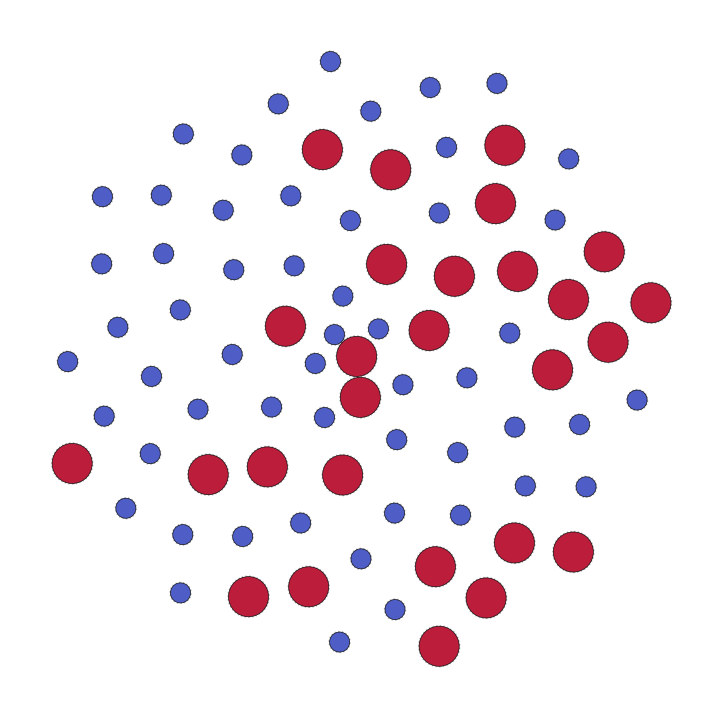

In [23]:
# --- Run Example ---
if __name__ == "__main__":
    # Test: 150 particles
    N_circles           = 81
    radius_1            = 10.0
    radius_2            = 20.0
    my_radii            = np.full(N_circles, radius_1)
    idx_large           = np.random.choice(np.arange(N_circles),N_circles//3,replace=False)
    my_radii[idx_large] = radius_2
    # my_radii            = np.random.uniform(5,20,N_circles)
    my_d_min            = 1.0
    
    packed_result = pack_circles_dense_cohesive(my_radii, d_min=my_d_min)
    
    visualize(my_radii, my_d_min, packed_result)